In [11]:
import pandas as pd

def merge_edge_metrics_groupwise(df):
    """
    Merges edge types within each (file, CE, model, etc.) group.
    - 'Cause->Consequence' → 'Cause->Mechanism'
    - 'Consequence->Critical_event' → 'Mechanism->Critical_event'
    """

    merge_map = {
        'Cause->Consequence': 'Cause->Mechanism',
        'Consequence->Critical_event': 'Mechanism->Critical_event'
    }

    metric_cols = ['TP', 'FP', 'FN', 'Precision', 'Recall', 'F1', 'Jaccard']
    group_cols = ['File', 'Critical Event', 'Model', 'Pipeline', 'Prompt', 'Part', 'Predicted CE']

    df = df.copy()
    df['Edge Type'] = df['Edge Type'].str.strip()

    grouped = df.groupby(group_cols, group_keys=False)

    updated_rows = []

    for _, group in grouped:
        group_copy = group.copy()
        for from_edge, to_edge in merge_map.items():
            from_rows = group_copy[group_copy['Edge Type'] == from_edge]
            if from_rows.empty:
                continue

            to_rows_mask = group_copy['Edge Type'] == to_edge
            if to_rows_mask.any():
                group_copy.loc[to_rows_mask, metric_cols] += from_rows[metric_cols].sum()
            else:
                # Change edge type and append
                new_rows = from_rows.copy()
                new_rows['Edge Type'] = to_edge
                group_copy = pd.concat([group_copy, new_rows], ignore_index=True)

            # Drop original from_rows
            group_copy = group_copy[group_copy['Edge Type'] != from_edge]

        updated_rows.append(group_copy)

    return pd.concat(updated_rows, ignore_index=True)

# Load your full results file
all_sheets = pd.read_excel("/Users/priyank/Desktop/llm_rag/downloads/metrics_20250512_234705.xlsx", sheet_name=None)

# Apply only to EdgeMetrics
if "EdgeMetrics" in all_sheets:
    all_sheets["EdgeMetrics"] = merge_edge_metrics_groupwise(all_sheets["EdgeMetrics"])

# Save all sheets back
with pd.ExcelWriter("/Users/priyank/Desktop/llm_rag/downloads/metrics_20250512_234705_fixed.xlsx", engine='openpyxl') as writer:
    for name, df in all_sheets.items():
        df.to_excel(writer, sheet_name=name, index=False)


# Join Metadata with Metrics

In [1]:
import pandas as pd

# === INPUT FILE PATHS ===
metadata_path = "/Users/priyank/Desktop/Reuslts/sobol_metadata_individual sensor_3_parameter.csv"
metrics_path = "/Users/priyank/Desktop/llm_rag/downloads/metrics_20250528_010118.xlsx"
output_path = "sobol_ready_output_run1.csv"

# === Load metadata ===
metadata_df = pd.read_csv(metadata_path)
metadata_df['File'] = metadata_df['json_path'].apply(lambda x: x.split('/')[-1].replace('.json', ''))

# === Load Excel Metrics ===
xls = pd.ExcelFile(metrics_path)
node_metrics = xls.parse("NodeMetrics")
edge_metrics = xls.parse("EdgeMetrics")
ged_metrics = xls.parse("GEDMetrics")

# === Node Metrics (Role == "Overall") ===
node_overall = node_metrics[node_metrics["Role"] == "Overall"]

# Check for duplicates
dupes = node_overall.duplicated(subset=["File", "Critical Event"], keep=False)
duplicate_rows = node_overall[dupes]

if not duplicate_rows.empty:
    print("⚠️ Duplicate 'Overall' rows found for some File + Critical Event combinations:")
    print(duplicate_rows[["File", "Critical Event"]])
else:
    print("✅ No duplicate Overall rows per File + Critical Event")

# Average Node F1/Jaccard over all CEs per File (enforced by column name)
node_agg = node_overall.groupby("File")[["F1", "Jaccard"]].mean().reset_index()
node_agg = node_agg.rename(columns={"F1": "Node_F1", "Jaccard": "Node_Jaccard"})

# === Edge Metrics (Edge Type == "Overall") ===
edge_overall = edge_metrics[edge_metrics["Edge Type"] == "Overall"]
edge_agg = edge_overall.groupby("File")[["F1", "Jaccard"]].mean().reset_index()
edge_agg = edge_agg.rename(columns={"F1": "Edge_F1", "Jaccard": "Edge_Jaccard"})

# === GED Metrics (average GED per CE, then per File) ===
ged_agg = ged_metrics.groupby(["File", "Critical Event"])[["GED"]].mean().reset_index()
ged_agg_file_avg = ged_agg.groupby("File")[["GED"]].mean().reset_index()

# === Merge all metrics ===
all_metrics = ged_agg_file_avg.merge(node_agg, on="File").merge(edge_agg, on="File")
final_df = metadata_df.merge(all_metrics, on="File")

# === Check for invalid F1/Jaccard values ===
invalid = final_df[
    (final_df["Node_F1"] > 1.0) | (final_df["Node_F1"] < 0.0) |
    (final_df["Node_Jaccard"] > 1.0) | (final_df["Node_Jaccard"] < 0.0) |
    (final_df["Edge_F1"] > 1.0) | (final_df["Edge_F1"] < 0.0) |
    (final_df["Edge_Jaccard"] > 1.0) | (final_df["Edge_Jaccard"] < 0.0)
]

if not invalid.empty:
    print("❌ Invalid F1 or Jaccard values found (outside [0.0, 1.0]):")
    print(invalid[["File", "Node_F1", "Node_Jaccard", "Edge_F1", "Edge_Jaccard"]])
else:
    print("✅ All Node/Edge F1 and Jaccard values are within [0.0, 1.0]")

# === Save ===
final_df.to_csv(output_path, index=False)
print(f"✅ Final Sobol-ready file saved as: {output_path}")


✅ No duplicate Overall rows per File + Critical Event
✅ All Node/Edge F1 and Jaccard values are within [0.0, 1.0]
✅ Final Sobol-ready file saved as: sobol_ready_output_run1.csv


# Per Model and Combined Sobol

/Users/priyank/Desktop/llm_rag/rag_env/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


✅ Sobol S1/ST/S2 analysis and plotting complete.


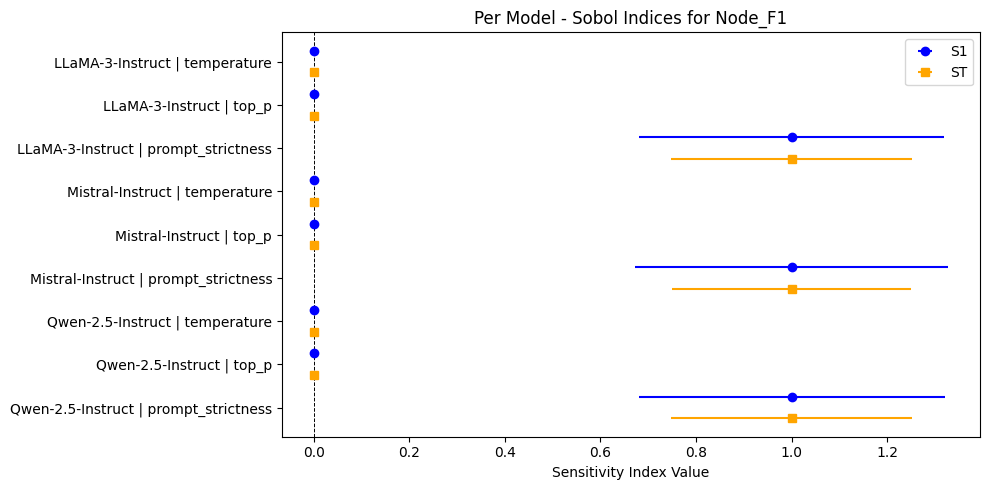

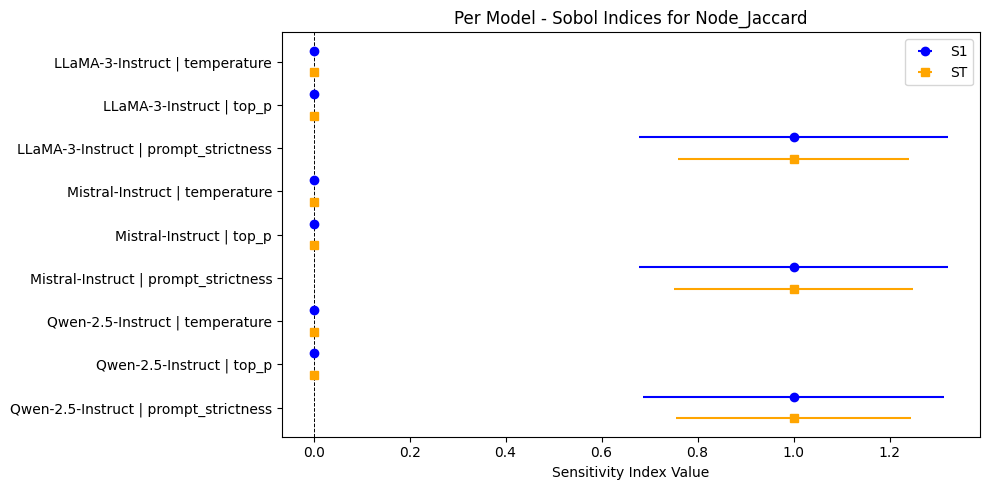

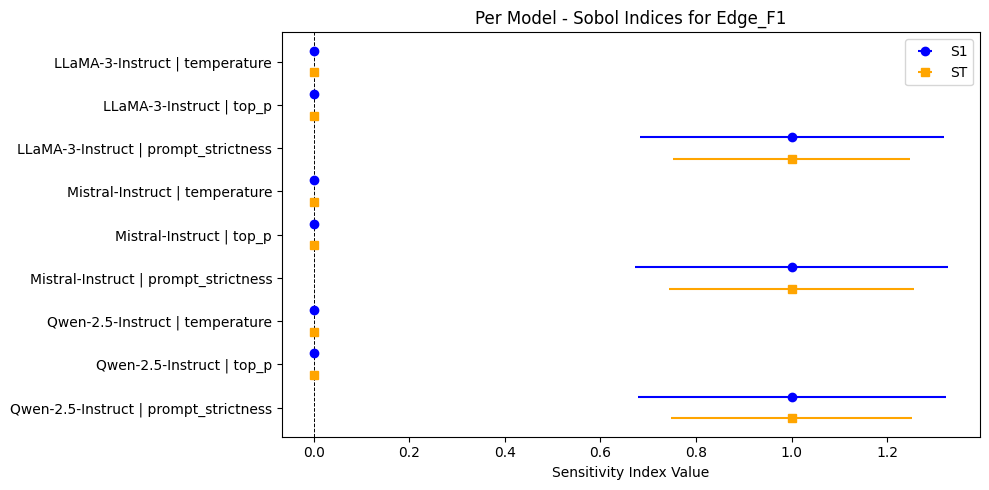

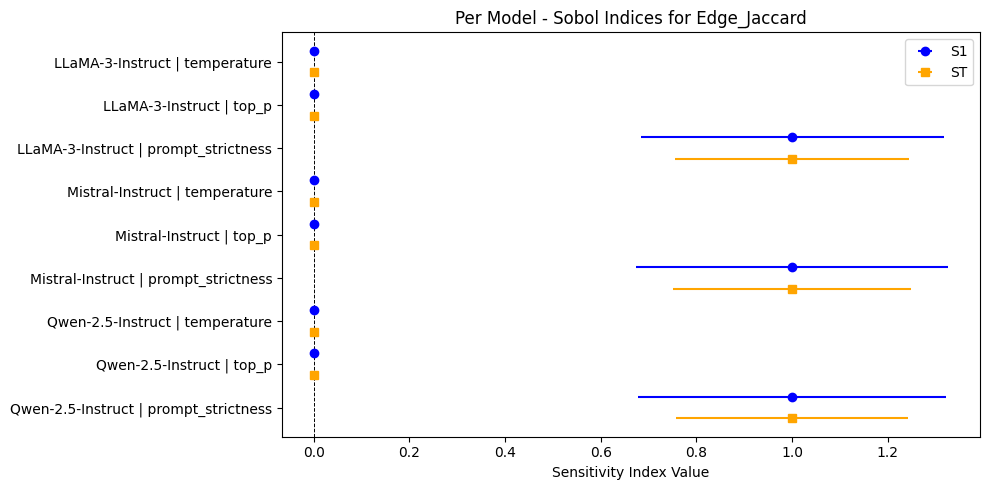

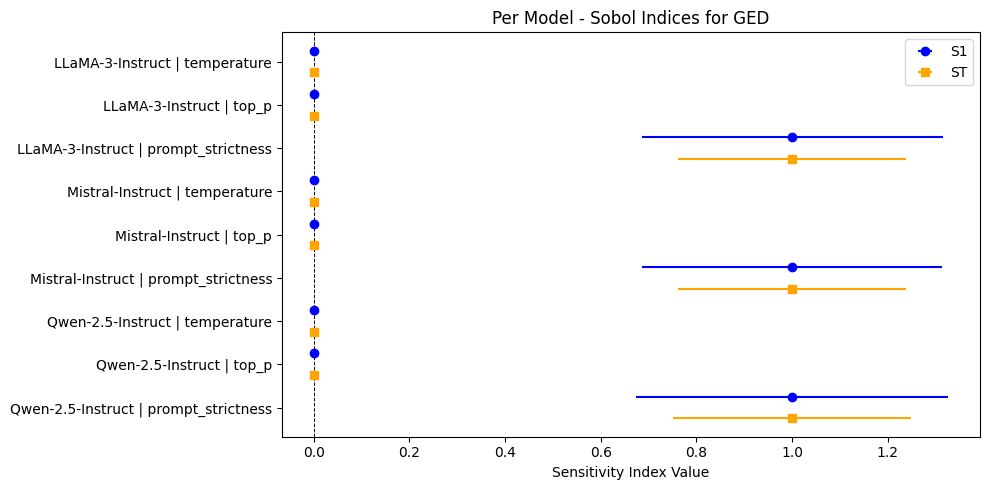

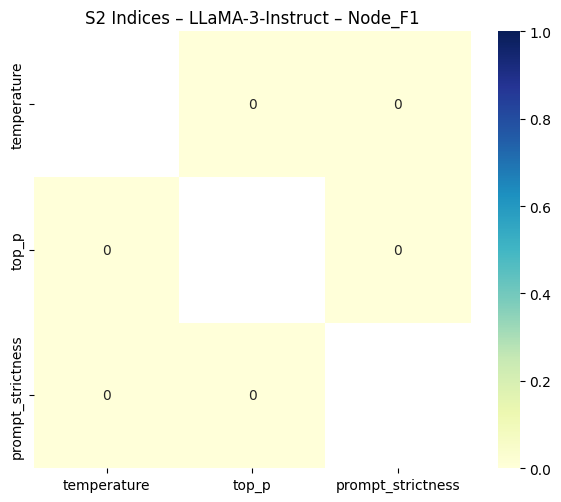

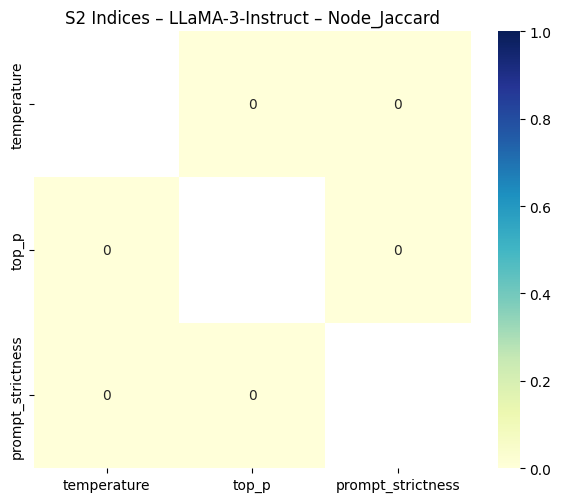

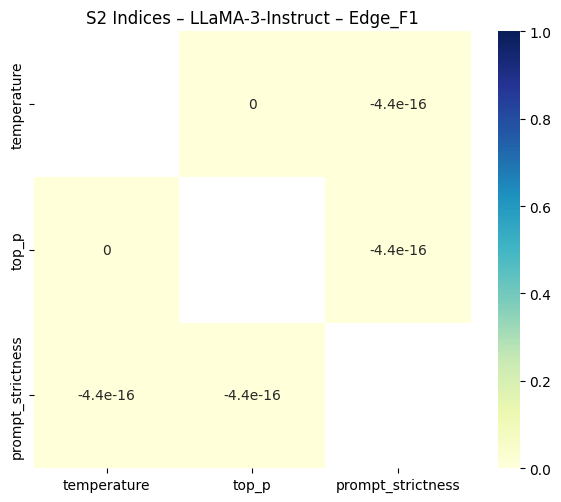

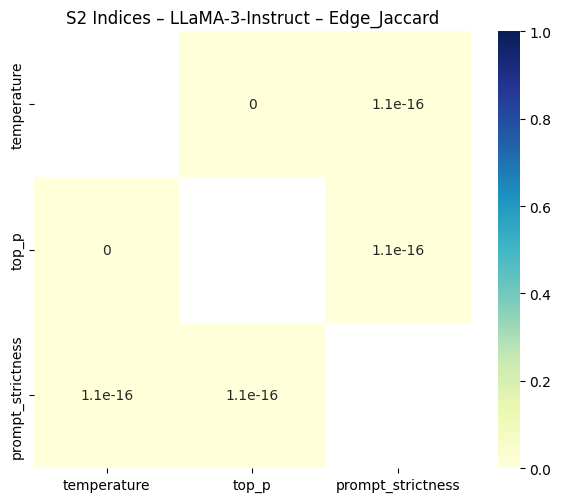

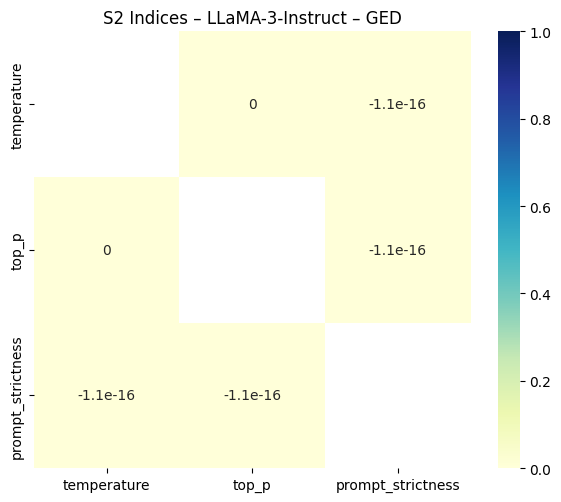

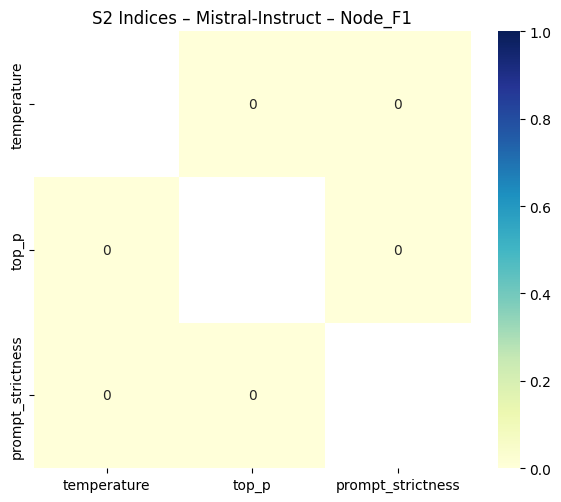

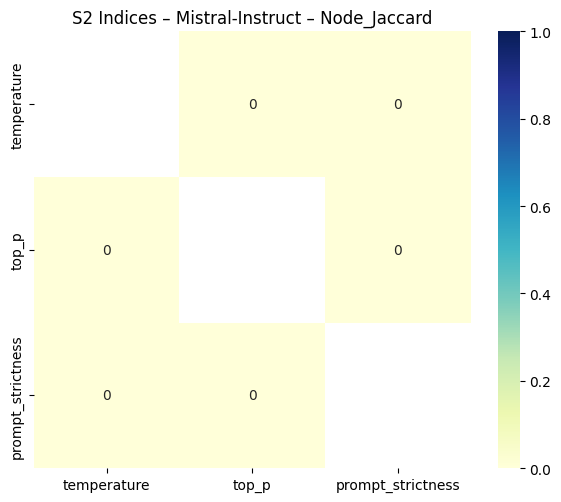

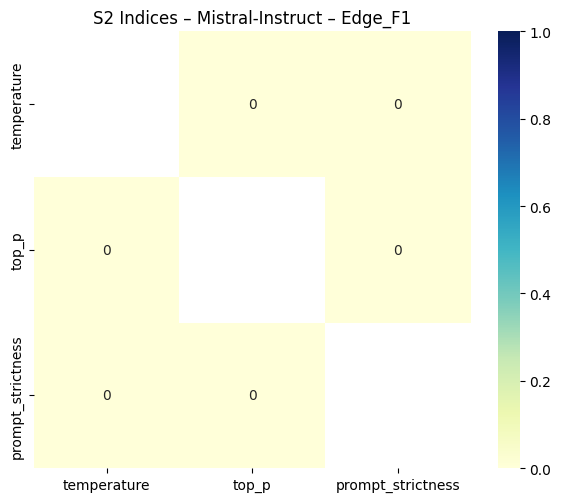

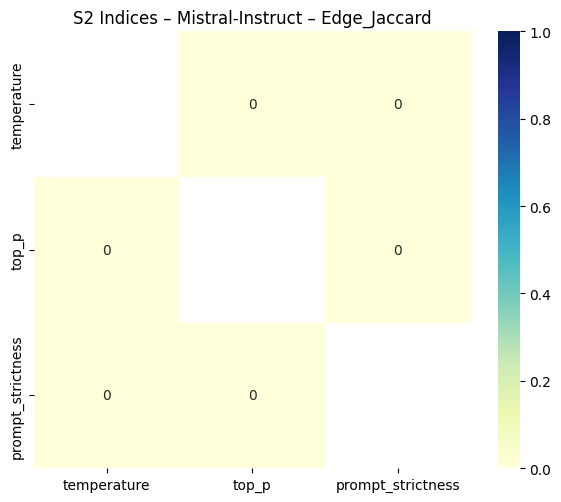

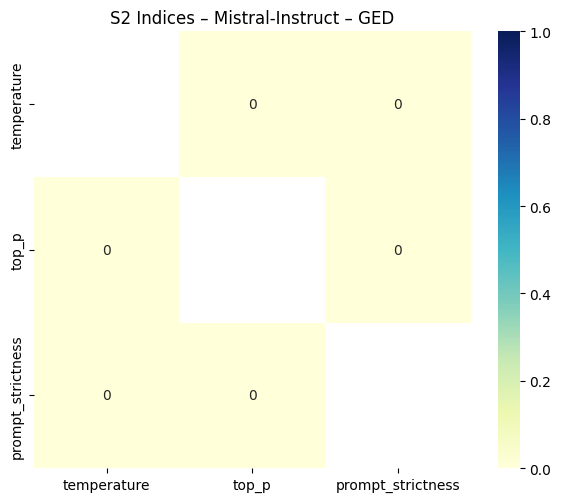

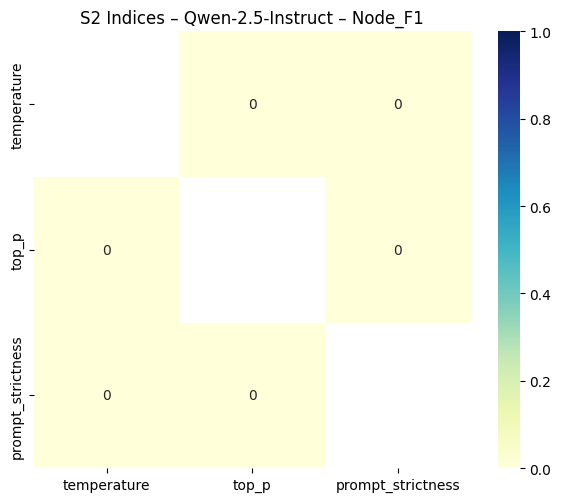

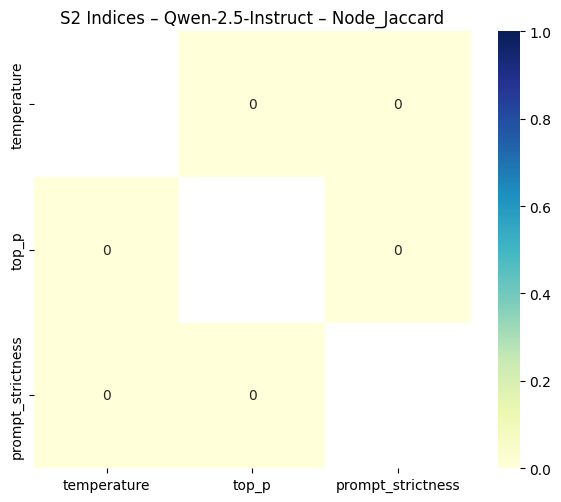

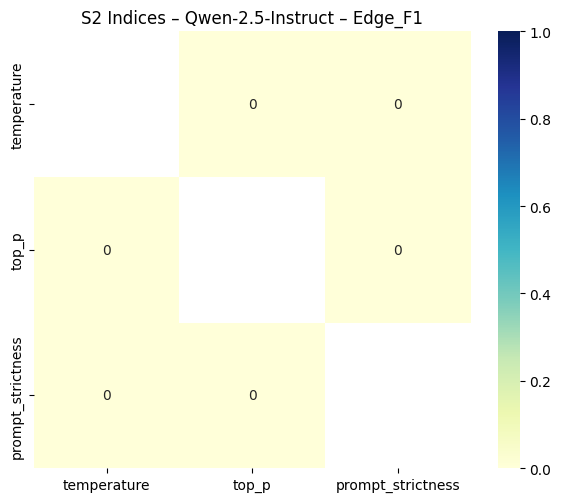

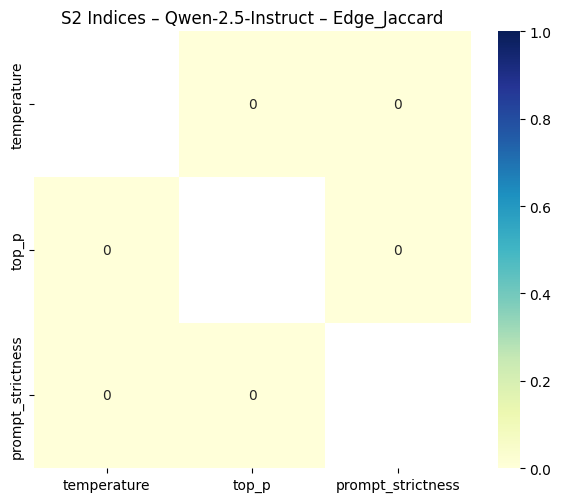

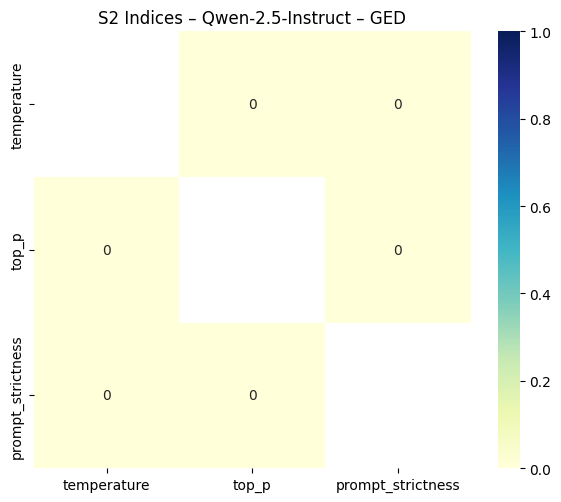

In [3]:
import pandas as pd
from SALib.analyze import sobol
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
# === CONFIG ===
INPUT_CSV = "sobol_ready_output_run1.csv"
PER_MODEL_OUTPUT = "sobol_s1_st_per_model.csv"
S2_OUTPUT = "sobol_s2_per_model.csv"
PLOTS_DIR = "sobol_plots"
N = 64
os.makedirs(PLOTS_DIR, exist_ok=True)

sobol_problem = {
    'num_vars': 3,
    'names': ['temperature', 'top_p', 'prompt_strictness'],
    'bounds': [[0.1, 1.0], [0.1, 1.0], [0, 3]]
}
metrics = ['Node_F1', 'Node_Jaccard', 'Edge_F1', 'Edge_Jaccard', 'GED']


# === Load data ===
df = pd.read_csv(INPUT_CSV)
expected_samples = N * (2 * len(sobol_problem['names']) + 2)

# === Remap model names ===
model_name_map = {
    "LLaMA-3-8B": "LLaMA-3-Instruct",
    "Mistral-7B": "Mistral-Instruct",
    "Qwen-7B": "Qwen-2.5-Instruct"
}
df["model"] = df["model"].map(model_name_map).fillna(df["model"])


# === Per-Model Sobol Analysis ===
per_model_results = []
s2_results = []

for model in df['model'].unique():
    model_df = df[df['model'] == model].reset_index(drop=True)
    for metric in metrics:
        Y = model_df[metric].values
        if len(Y) < expected_samples:
            print(f"Skipping {model} {metric}: only {len(Y)} samples (expected {expected_samples})")
            continue
        try:
            Si = sobol.analyze(
                sobol_problem, Y,
                calc_second_order=True,
                num_resamples=1000,
                print_to_console=False
            )

            # First-order and total-order
            for i, param in enumerate(sobol_problem['names']):
                per_model_results.append({
                    "Model": model,
                    "Metric": metric,
                    "Parameter": param,
                    "S1": Si['S1'][i],
                    "S1_conf": Si['S1_conf'][i],
                    "ST": Si['ST'][i],
                    "ST_conf": Si['ST_conf'][i]
                })

            # Second-order
            for i in range(len(sobol_problem['names'])):
                for j in range(i + 1, len(sobol_problem['names'])):
                    s2_results.append({
                        "Model": model,
                        "Metric": metric,
                        "Param_1": sobol_problem['names'][i],
                        "Param_2": sobol_problem['names'][j],
                        "S2": Si['S2'][i, j],
                        "S2_conf": Si['S2_conf'][i, j]
                    })

        except Exception as e:
            print(f"Error in per-model analysis for {model} {metric}: {e}")

# === Save results ===
per_model_df = pd.DataFrame(per_model_results)
per_model_df.to_csv(PER_MODEL_OUTPUT, index=False)
s2_df = pd.DataFrame(s2_results)
s2_df.to_csv(S2_OUTPUT, index=False)

# === Plotting S1 and ST ===
def plot_s1_st(df, title_prefix):
    for metric in df['Metric'].unique():
        metric_df = df[df['Metric'] == metric]
        fig, ax = plt.subplots(figsize=(10, 5))
        y_labels = []
        y_pos = []
        spacing = 0.25

        for idx, (_, row) in enumerate(metric_df.iterrows()):
            y = idx
            y_labels.append(f"{row['Model']} | {row['Parameter']}")
            y_pos.append(y)
            ax.errorbar(row['S1'], y - spacing, xerr=row['S1_conf'], fmt='o', color='blue', label='S1' if idx == 0 else "")
            ax.errorbar(row['ST'], y + spacing, xerr=row['ST_conf'], fmt='s', color='orange', label='ST' if idx == 0 else "")

        ax.set_yticks(y_pos)
        ax.set_yticklabels(y_labels)
        ax.axvline(0, color='black', linestyle='--', linewidth=0.7)
        ax.set_title(f"{title_prefix} - Sobol Indices for {metric}")
        ax.set_xlabel("Sensitivity Index Value")
        ax.invert_yaxis()
        ax.legend()
        plt.tight_layout()
        # plt.savefig(os.path.join(PLOTS_DIR, f"{title_prefix}_{metric}_S1_ST.png"))
        # plt.close()
        
def plot_s2_heatmap(df):
    params = sobol_problem['names']
    for model in df["Model"].unique():
        for metric in df["Metric"].unique():
            subset = df[(df["Model"] == model) & (df["Metric"] == metric)]
            if subset.empty:
                continue

            # Create symmetric S2 matrix
            matrix = pd.DataFrame(np.nan, index=params, columns=params)
            for _, row in subset.iterrows():
                p1, p2 = row["Param_1"], row["Param_2"]
                matrix.loc[p1, p2] = row["S2"]
                matrix.loc[p2, p1] = row["S2"]  # make symmetric

            fig, ax = plt.subplots(figsize=(6, 5))
            sns.heatmap(matrix, annot=True, cmap="YlGnBu", vmin=0, vmax=1, square=True, cbar=True, ax=ax)
            ax.set_title(f"S2 Indices – {model} – {metric}")
            plt.tight_layout()
            # plt.savefig(os.path.join(PLOTS_DIR, f"S2_{model}_{metric}.png"))
            # plt.close(fig)


# === Generate plots ===
if not per_model_df.empty:
    plot_s1_st(per_model_df, "Per Model")
if not s2_df.empty:
    plot_s2_heatmap(s2_df)

print("✅ Sobol S1/ST/S2 analysis and plotting complete.")


# Normality Testing

In [9]:
import pandas as pd
from scipy.stats import shapiro, levene, f_oneway, kruskal

# === Load your Sobol metrics ===
df = pd.read_csv("sobol_ready_output_run1.csv")

# === Metrics to evaluate ===
metrics = ["Node_F1", "Node_Jaccard", "Edge_F1", "Edge_Jaccard", "GED"]

for metric in metrics:
    print(f"\n📊 Metric: {metric}")
    for level in sorted(df['prompt_strictness'].unique()):
        print(f"\n🔍 Prompt Strictness Level: {level}")
        subset = df[df['prompt_strictness'] == level]
        grouped = subset.groupby("model")[metric]
        data_groups = [group.dropna().values for _, group in grouped]

        # Step 1: Normality test per group (Shapiro-Wilk)
        all_normal = True
        for model, group in grouped:
            stat, p = shapiro(group)
            normal = p > 0.05
            all_normal = all_normal and normal
            print(f"   {model} - Shapiro p={p:.2e} → {'✅ normal' if normal else '❌ not normal'}")

        # Step 2: Equal variance test (Levene)
        try:
            stat, p_var = levene(*data_groups)
            equal_var = p_var > 0.05
            print(f"   Levene p={p_var:.2e} → {'✅ equal variance' if equal_var else '❌ unequal variance'}")
        except Exception as e:
            print(f"   ⚠️ Levene's test failed: {e}")
            equal_var = False

        # Step 3: Decide test
        flattened = [item for group in data_groups for item in group]
        all_identical = len(set(flattened)) == 1
        
        if all_identical:
            print(f"   ⚠️ Skipping Kruskal-Wallis: All values identical for {metric} at prompt level {level}")
            continue


        if all_normal and equal_var:
            stat, p_final = f_oneway(*data_groups)
            test_type = "ANOVA"
        else:
            stat, p_final = kruskal(*data_groups)
            test_type = "Kruskal-Wallis"

        print(f"👉 Using {test_type}: p = {p_final:.2e}")
        if p_final < 0.05:
            print("   ❗ Significant difference between models")
        else:
            print("   ✅ No significant difference between models")



📊 Metric: Node_F1

🔍 Prompt Strictness Level: 0
   LLaMA-3-8B - Shapiro p=1.00e+00 → ✅ normal
   Mistral-7B - Shapiro p=1.00e+00 → ✅ normal
   Qwen-7B - Shapiro p=1.00e+00 → ✅ normal
   Levene p=nan → ❌ unequal variance
👉 Using Kruskal-Wallis: p = 3.13e-55
   ❗ Significant difference between models

🔍 Prompt Strictness Level: 1
   LLaMA-3-8B - Shapiro p=1.00e+00 → ✅ normal
   Mistral-7B - Shapiro p=1.00e+00 → ✅ normal
   Qwen-7B - Shapiro p=1.00e+00 → ✅ normal
   Levene p=nan → ❌ unequal variance
👉 Using Kruskal-Wallis: p = 2.51e-279
   ❗ Significant difference between models

📊 Metric: Node_Jaccard

🔍 Prompt Strictness Level: 0
   LLaMA-3-8B - Shapiro p=1.00e+00 → ✅ normal
   Mistral-7B - Shapiro p=1.00e+00 → ✅ normal
   Qwen-7B - Shapiro p=1.00e+00 → ✅ normal
   Levene p=nan → ❌ unequal variance
👉 Using Kruskal-Wallis: p = 3.13e-55
   ❗ Significant difference between models

🔍 Prompt Strictness Level: 1
   LLaMA-3-8B - Shapiro p=1.00e+00 → ✅ normal
   Mistral-7B - Shapiro p=1.00e+00

/Users/priyank/Desktop/llm_rag/rag_env/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/priyank/Desktop/llm_rag/rag_env/lib/python3.11/site-packages/scipy/stats/_morestats.py:3345: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
/Users/priyank/Desktop/llm_rag/rag_env/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/priyank/Desktop/llm_rag/rag_env/lib/python3.11/site-packages/scipy/stats/_morestats.py:3345: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
/Users/priyank/Desktop/llm_rag/rag_env/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has rang

# Do models differ at each prompt level?
- Model Comparison within Prompt Level
- At a given prompt strictness level (e.g., prompt 1), do different models produce significantly different metric scores?
- Prompt is fixed.
- Comparing performance across models.
- Useful for: Ranking models under each prompt condition.

In [1]:
import pandas as pd
import scikit_posthocs as sp
from itertools import combinations

# Load your Sobol-ready metrics file
df = pd.read_csv("sobol_ready_output_run1.csv")

metrics = ["Node_F1", "Node_Jaccard", "Edge_F1", "Edge_Jaccard", "GED"]

def cliffs_delta(x, y):
    m, n = len(x), len(y)
    more = sum([1 for xi in x for yi in y if xi > yi])
    less = sum([1 for xi in x for yi in y if xi < yi])
    return (more - less) / (m * n)

# === BLOCK 1: Model Comparison Within Each Prompt Level ===
print("\n=== BLOCK 1: Model Comparison Per Prompt Level ===")
for metric in metrics:
    print(f"\n📊 Metric: {metric}")
    for level in sorted(df['prompt_strictness'].unique()):
        subset = df[df['prompt_strictness'] == level]
        if subset['model'].nunique() < 2:
            continue
        print(f"\n🔍 Prompt Level: {level}")

        # Dunn's test
        dunn = sp.posthoc_dunn(subset, val_col=metric, group_col='model', p_adjust='bonferroni')
        print("Dunn's p-values:")
        print(dunn)

        # Cliff’s delta
        print("Cliff's Delta:")
        for m1, m2 in combinations(subset['model'].unique(), 2):
            x = subset[subset['model'] == m1][metric].values
            y = subset[subset['model'] == m2][metric].values
            delta = cliffs_delta(x, y)
            print(f"  {m1} vs {m2}: {delta:.3f}")



=== BLOCK 1: Model Comparison Per Prompt Level ===

📊 Metric: Node_F1

🔍 Prompt Level: 0
Dunn's p-values:
              LLaMA-3-8B    Mistral-7B       Qwen-7B
LLaMA-3-8B  1.000000e+00  8.297400e-85  3.910395e-22
Mistral-7B  8.297400e-85  1.000000e+00  3.910395e-22
Qwen-7B     3.910395e-22  3.910395e-22  1.000000e+00
Cliff's Delta:
  LLaMA-3-8B vs Mistral-7B: -1.000
  LLaMA-3-8B vs Qwen-7B: -1.000
  Mistral-7B vs Qwen-7B: 1.000

🔍 Prompt Level: 1
Dunn's p-values:
               LLaMA-3-8B    Mistral-7B        Qwen-7B
LLaMA-3-8B   1.000000e+00  3.957984e-43  2.421951e-168
Mistral-7B   3.957984e-43  1.000000e+00   3.957984e-43
Qwen-7B     2.421951e-168  3.957984e-43   1.000000e+00
Cliff's Delta:
  LLaMA-3-8B vs Mistral-7B: -1.000
  LLaMA-3-8B vs Qwen-7B: -1.000
  Mistral-7B vs Qwen-7B: -1.000

🔍 Prompt Level: 2
Dunn's p-values:
              LLaMA-3-8B    Mistral-7B       Qwen-7B
LLaMA-3-8B  1.000000e+00  5.927716e-64  5.927716e-64
Mistral-7B  5.927716e-64  1.000000e+00  1.000000e+00
Qwe

/Users/priyank/Desktop/llm_rag/rag_env/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:366: RuntimeWarning: invalid value encountered in scalar divide
  z_value = diff / np.sqrt((A - x_ties) * B)
/Users/priyank/Desktop/llm_rag/rag_env/lib/python3.11/site-packages/scikit_posthocs/_posthocs.py:366: RuntimeWarning: invalid value encountered in scalar divide
  z_value = diff / np.sqrt((A - x_ties) * B)


# Prompt levels within each model
-  Does a model perform significantly differently under different prompt scaffolding levels?
-  Model is fixed.
-  Comparing performance across prompt strictness levels.
-  Useful for: Evaluating the benefit of structured prompting per model.

In [3]:

# === BLOCK 2: Prompt Comparison Within Each Model ===
print("\n=== BLOCK 2: Prompt Comparison Per Model ===")
for metric in metrics:
    print(f"\n📊 Metric: {metric}")
    for model in sorted(df['model'].unique()):
        subset = df[df['model'] == model]
        if subset['prompt_strictness'].nunique() < 2:
            continue
        print(f"\n🔍 Model: {model}")

        # Dunn's test
        dunn = sp.posthoc_dunn(subset, val_col=metric, group_col='prompt_strictness', p_adjust='bonferroni')
        print("Dunn's p-values:")
        print(dunn)

        # Cliff’s delta
        print("Cliff's Delta:")
        for l1, l2 in combinations(sorted(subset['prompt_strictness'].unique()), 2):
            x = subset[subset['prompt_strictness'] == l1][metric].values
            y = subset[subset['prompt_strictness'] == l2][metric].values
            delta = cliffs_delta(x, y)
            print(f"  Prompt {l1} vs {l2}: {delta:.3f}")



=== BLOCK 2: Prompt Comparison Per Model ===

📊 Metric: Node_F1

🔍 Model: LLaMA-3-8B
Dunn's p-values:
               0              1             2
0   1.000000e+00  2.608398e-100  1.370264e-75
1  2.608398e-100   1.000000e+00  1.000000e+00
2   1.370264e-75   1.000000e+00  1.000000e+00
Cliff's Delta:
  Prompt 0 vs 1: -1.000
  Prompt 0 vs 2: -1.000
  Prompt 1 vs 2: 0.000

🔍 Model: Mistral-7B
Dunn's p-values:
               0             1              2
0   1.000000e+00  1.877089e-38  1.152829e-112
1   1.877089e-38  1.000000e+00   1.877089e-38
2  1.152829e-112  1.877089e-38   1.000000e+00
Cliff's Delta:
  Prompt 0 vs 1: -1.000
  Prompt 0 vs 2: -1.000
  Prompt 1 vs 2: -1.000

🔍 Model: Qwen-7B
Dunn's p-values:
               0             1              2
0   1.000000e+00  1.877089e-38  1.152829e-112
1   1.877089e-38  1.000000e+00   1.877089e-38
2  1.152829e-112  1.877089e-38   1.000000e+00
Cliff's Delta:
  Prompt 0 vs 1: -1.000
  Prompt 0 vs 2: -1.000
  Prompt 1 vs 2: -1.000

📊 Metric: N

# Metrics breakdown by Model and Prompt Strictness

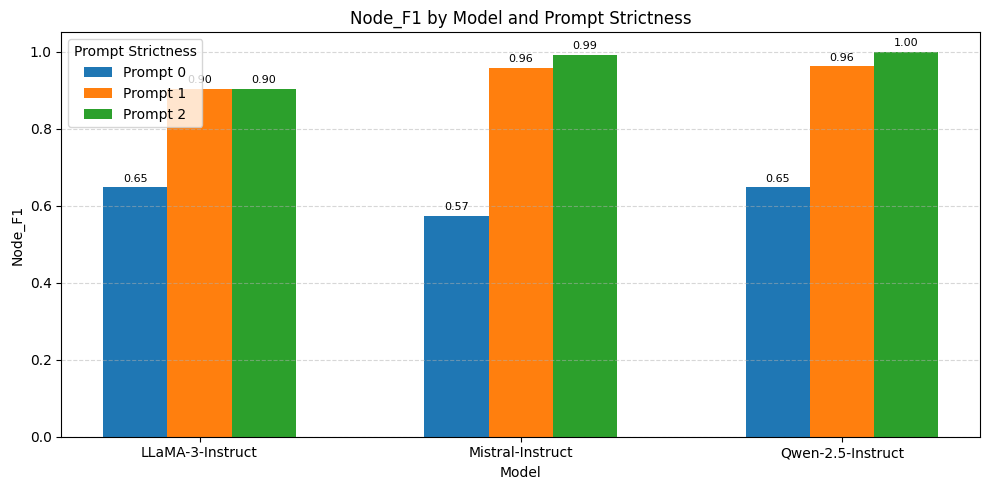

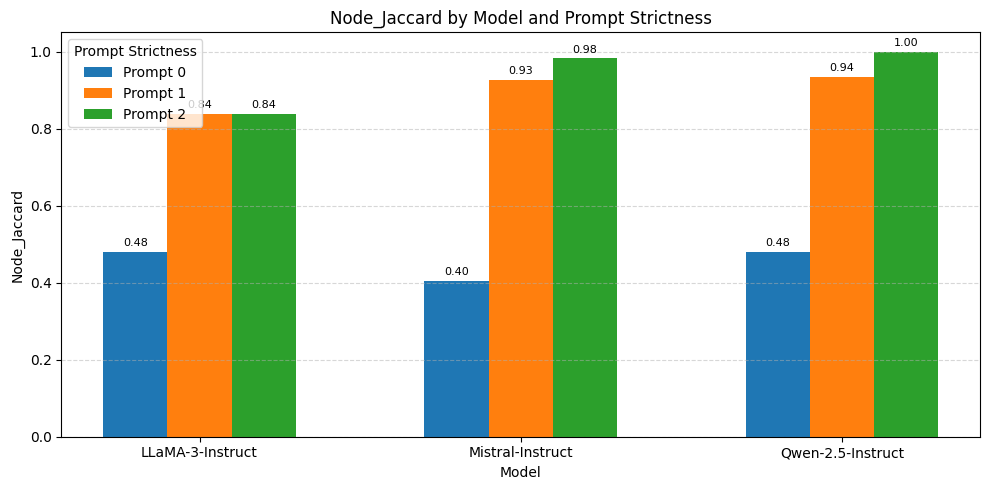

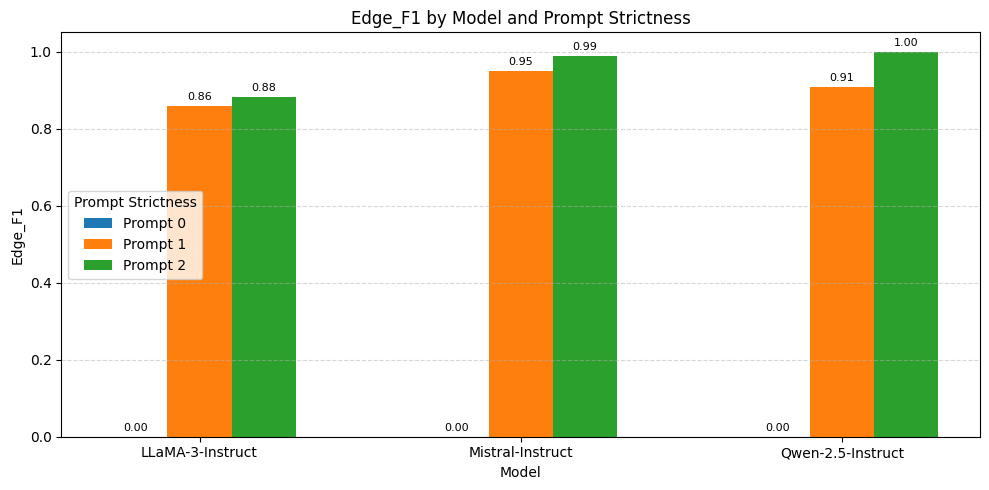

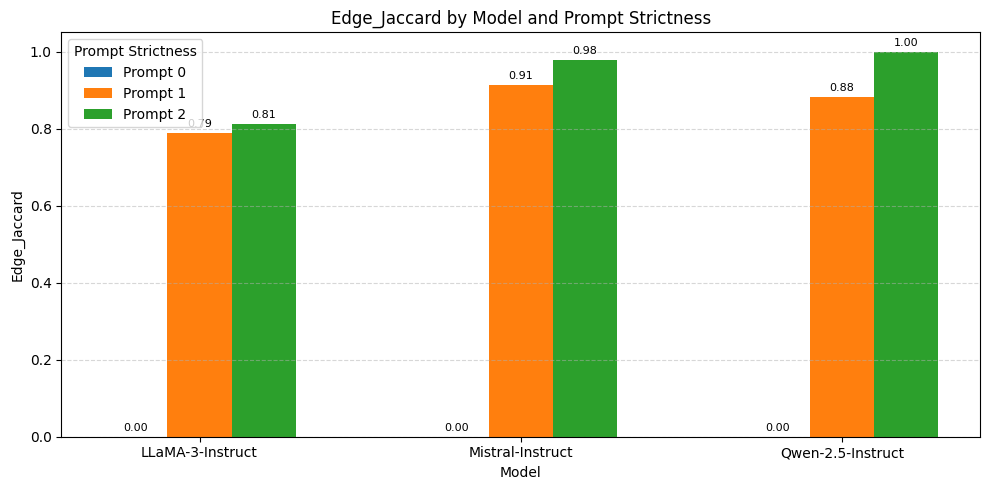

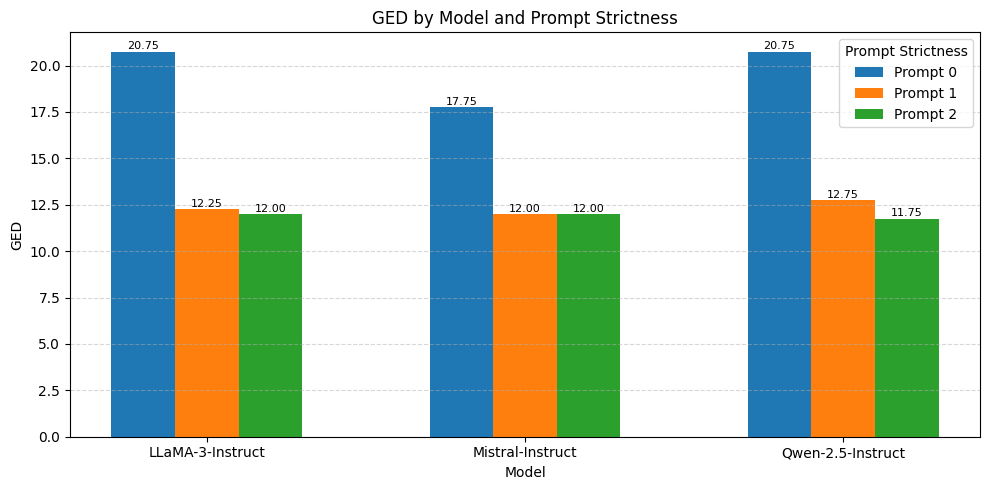

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Sobol-ready dataset
df = pd.read_csv("sobol_ready_output_v2.csv")

# === Remap model names for clarity ===
model_name_map = {
    "LLaMA-3-8B": "LLaMA-3-Instruct",
    "Mistral-7B": "Mistral-Instruct",
    "Qwen-7B": "Qwen-2.5-Instruct"
}
df["model"] = df["model"].map(model_name_map).fillna(df["model"])


# Metrics to visualize
metrics = ['Node_F1', 'Node_Jaccard', 'Edge_F1', 'Edge_Jaccard', 'GED']
models = sorted(df['model'].unique())
bar_width = 0.2
prompt_levels = sorted(df['prompt_strictness'].unique())

# Group data
grouped = df.groupby(["model", "prompt_strictness"])[metrics].agg(["mean", "std"]).reset_index()
grouped.columns = ["model", "prompt_strictness"] + [f"{m}_{stat}" for m in metrics for stat in ["mean", "std"]]

# Create plots
for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 5))
    for i, prompt in enumerate(prompt_levels):
        subset = grouped[grouped["prompt_strictness"] == prompt].set_index("model").reindex(models).reset_index()
        x_positions = [x + bar_width * i for x in range(len(models))]
        
        bars = ax.bar(
            x_positions,
            subset[f"{metric}_mean"],
            yerr=subset[f"{metric}_std"],
            width=bar_width,
            label=f"Prompt {prompt}"
        )
        
        # Add text labels to bars
        for x, y in zip(x_positions, subset[f"{metric}_mean"]):
            ax.text(x, y + 0.01, f"{y:.2f}", ha='center', va='bottom', fontsize=8)

    ax.set_title(f"{metric} by Model and Prompt Strictness")
    ax.set_xlabel("Model")
    ax.set_ylabel(metric)
    ax.set_xticks([r + bar_width * (len(prompt_levels) - 1) / 2 for r in range(len(models))])
    ax.set_xticklabels(models)
    ax.legend(title="Prompt Strictness")
    ax.yaxis.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


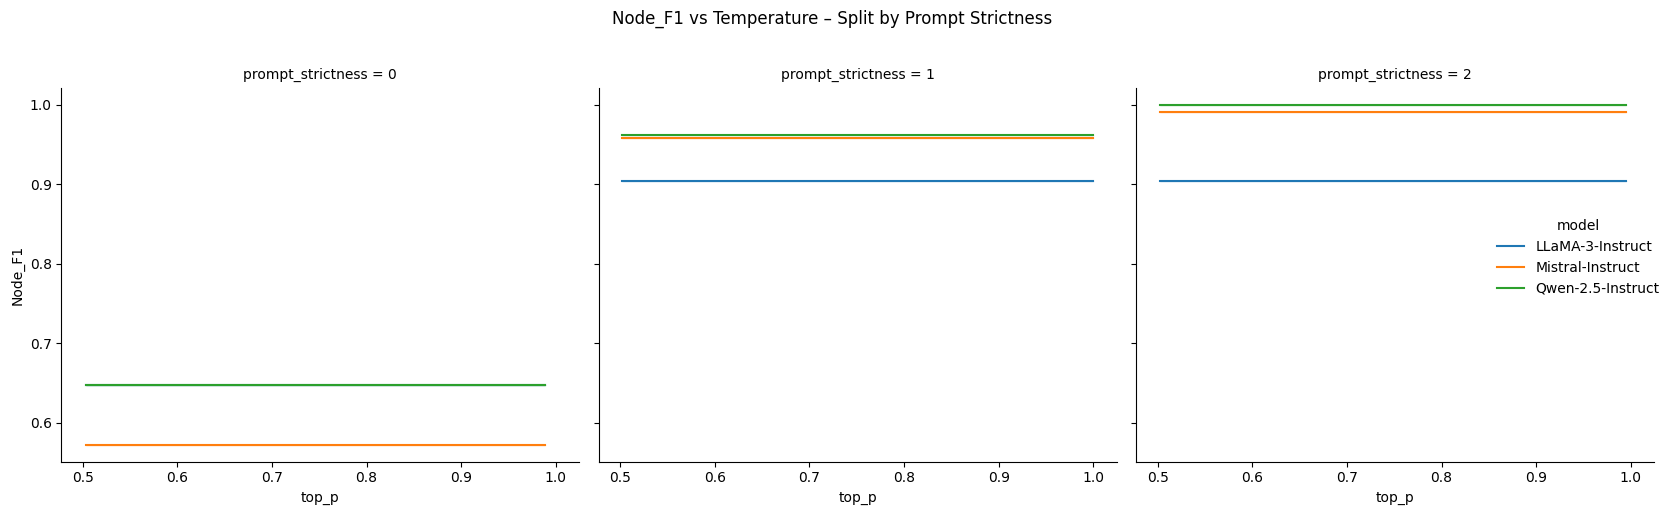

In [13]:
sns.relplot(
    data=df,
    x="top_p",
    y="Node_F1",
    hue="model",
    col="prompt_strictness",
    kind="line",
    col_wrap=3
)
plt.suptitle("Node_F1 vs Temperature – Split by Prompt Strictness", y=1.02)
plt.tight_layout()
plt.show()


# Hallucination variation

<Figure size 1600x800 with 0 Axes>

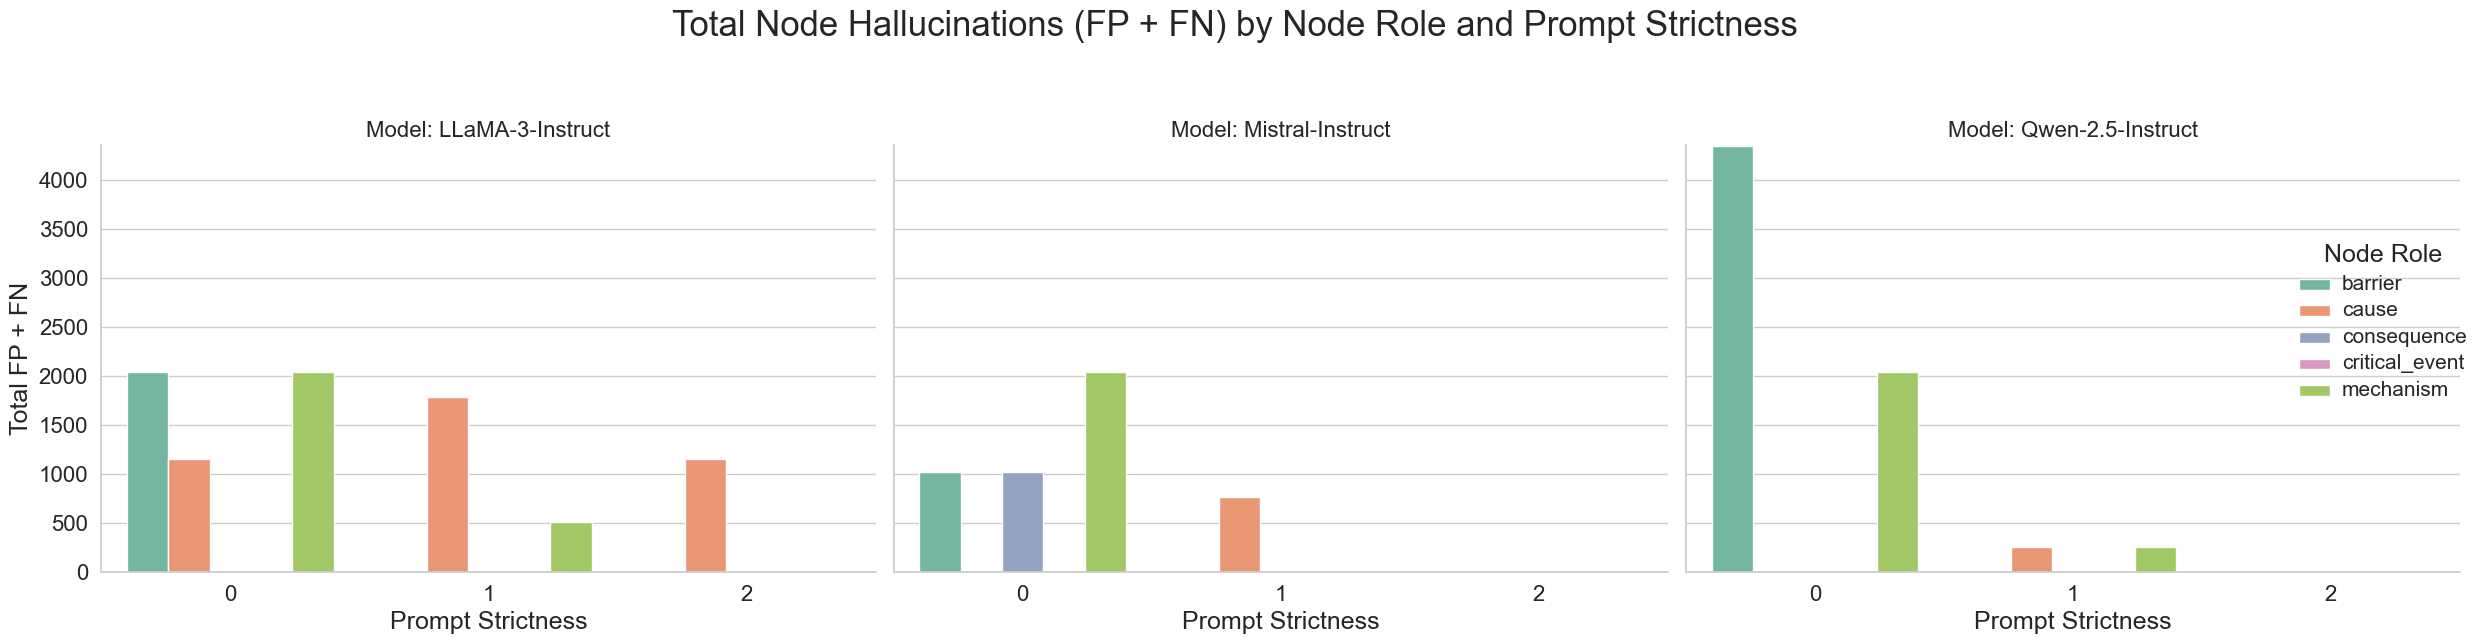

<Figure size 1600x800 with 0 Axes>

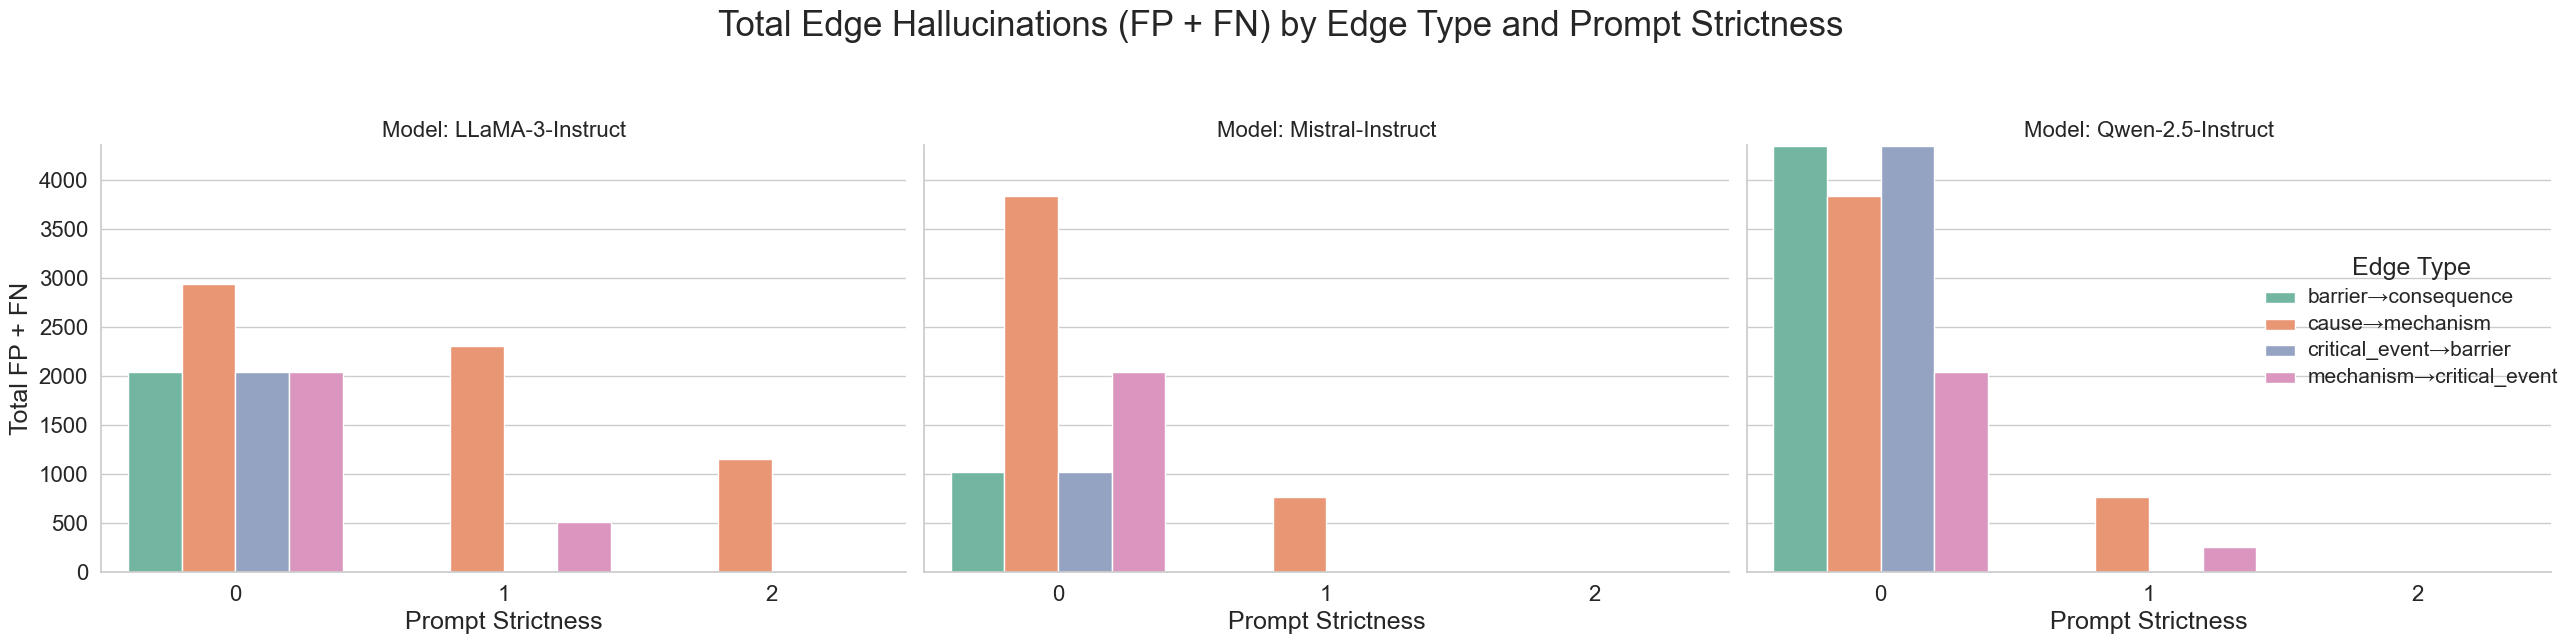

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# === File Paths ===
node_metrics_path = "/Users/priyank/Desktop/llm_rag/downloads/metrics_20250528_010118.xlsx"
sobol_metadata_path = "/Users/priyank/Desktop/Reuslts/sobol_metadata_individual sensor_3_parameter.csv"

# === Load Sheets ===
node_metrics = pd.read_excel(node_metrics_path, sheet_name="NodeMetrics")
edge_metrics = pd.read_excel(node_metrics_path, sheet_name="EdgeMetrics")
sobol_metadata = pd.read_csv(sobol_metadata_path)
PLOTS_DIR = "sobol_plots"

# === Prepare Metadata (fix filenames) ===
sobol_metadata["File"] = sobol_metadata["json_path"].apply(
    lambda x: os.path.basename(str(x)).replace(".json", "").replace(".txt", "")
)

# === Common Function: Summarize FP + FN ===
def summarize_fp_fn(df, role_col, label="Node"):
    df = df.copy()
    df[role_col] = df[role_col].astype(str).str.strip().str.lower()
    df = pd.merge(df, sobol_metadata[["File", "prompt_strictness", "model"]], on="File", how="left")
    df = df[~df[role_col].str.contains("overall")].copy()
    df["prompt_strictness"] = df["prompt_strictness"].astype(str)

    # === Remap model names ===
    model_name_map = {
        "LLaMA-3-8B": "LLaMA-3-Instruct",
        "Mistral-7B": "Mistral-Instruct",
        "Qwen-7B": "Qwen-2.5-Instruct"
    }
    df["model"] = df["model"].map(model_name_map).fillna(df["model"])

    summary = (
        df.groupby(["model", "prompt_strictness", role_col])
        .agg(
            total_FP=("FP", "sum"),
            total_FN=("FN", "sum"),
            total_CEs=("Critical Event", "nunique")
        )
        .reset_index()
    )

    summary["Total_FP_FN"] = summary["total_FP"] + summary["total_FN"]
    summary.rename(columns={role_col: "Role"}, inplace=True)
    summary["Type"] = label
    return summary


# === Summarize for Nodes and Edges ===
node_summary = summarize_fp_fn(node_metrics, role_col="Role", label="Node")
edge_summary = summarize_fp_fn(edge_metrics, role_col="Edge Type", label="Edge")

# Plot function with enhanced font sizes
def plot_faceted_summary_enhanced(summary_df, label):
    sns.set(style="whitegrid")
    plt.figure(figsize=(16, 8))

    g = sns.catplot(
        data=summary_df,
        x="prompt_strictness",
        y="Total_FP_FN",
        hue="Role",
        col="model",
        kind="bar",
        height=6,
        aspect=1.3,
        palette="Set2",
        legend=True
    )

    g.set_axis_labels("Prompt Strictness", "Total FP + FN")
    g.set_titles("Model: {col_name}")
    g.set(ylim=(0, summary_df["Total_FP_FN"].max() + 5))

    for ax in g.axes.flat:
        ax.title.set_size(16)
        ax.set_xlabel("Prompt Strictness", fontsize=18)
        ax.set_ylabel("Total FP + FN", fontsize=18)
        ax.tick_params(labelsize=16)

    suptitle = f"Total {label} Hallucinations (FP + FN) by {'Node Role' if label == 'Node' else 'Edge Type'} and Prompt Strictness"
    g.fig.suptitle(suptitle, fontsize=25, y=1.07)

    legend_title = "Node Role" if label == "Node" else "Edge Type"
    g._legend.set_title(legend_title)
    for text in g._legend.texts:
        text.set_fontsize(15)
    g._legend.set_title(legend_title, prop={'size': 18})

    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, f"halucination.png"))

    plt.show()

# Display plots
plot_faceted_summary_enhanced(node_summary, label="Node")
plot_faceted_summary_enhanced(edge_summary, label="Edge")